## Working with GLAD velocity data using Clouddrift (For Beginners)

This notebook demonstrates where to start and how to work with the Grand LAgrangian Deployment (GLAD) dataset using [Clouddrift](https://github.com/Cloud-Drift/clouddrift). Specifically, we will show how to load the data, visualize it, and perform some basic operations.

The dataset's [information page](https://data.griidc.org/data/R1.x134.073:0004) describes the data as follows:

>297 trajectories from near-surface CODE-type ocean drifters (drogued at a depth of one meter) tracked in real-time using SPOT GPS units, launched in the northern Gulf of Mexico near DeSoto Canyon in July 2012 as part of the CARTHE Grand Lagrangian Deployment (GLAD) experiment. Most of these drifters were launched as triplets (separated by roughly 100 meters at launch) in an attempt to measure multi-scale near surface dispersion. Positions are low-pass filtered (one hour cutoff period) and interpolated to uniform 15 minute intervals starting on whole hours over the period July 20 through October 22, 2012. No temperature or salinity sensors were attached to these drifters. This dataset was created by the Consortium for Advanced Research on Transport of Hydrocarbon in the Environment (CARTHE). This research was made possible by a grant from BP/The Gulf of Mexico Research Initiative.


#### Importing the required libraries

In [2]:
# library imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# clouddrift import
import clouddrift as cd

#### Loading the data

To load the data, we simply need to call the GLAD specific load function for the GLAD dataset. Like the GLAD dataset, other available datasets have their own load functions that can be called in the same way. Each of these functions returns a ragged array as a `xarray.Dataset`.

In [3]:
# load the GLAD dataset
ds = cd.datasets.glad()

/root/.clouddrift/data/glad.nc not found; download from upstream repository.


retrying download request for (dst, src): ('https://data.gulfresearchinitiative.org/pelagos-symfony/api/file/download/169841', 'io-buffer'), attempt: 2
https://data.gulfresearchinitiative.org/pelagos-symfony/api/file/download/169841: 100%|██████████| 148M/148M [07:49<00:00, 331kB/s]  


Simply calling the `ds` `xarray.Dataset` will display information about the dataset, including the dimensions, coordinates, and data variables.

Under `Dimensions`, we see `obs` and `traj`, which represent the number of observations (total) and trajectories, respectively. The `Coordinates` section lists the `time` and `id`, which is a convention in `clouddrift` in order to keep track of the identification numbers of the drifter. Under the `Data variables` section, we see the variables along with their size (in parentheses) and data type. Lastly, metadata is also displayed in the `Attributes` section.

In [4]:
ds

<xarray.Dataset> Size: 51MB
Dimensions:         (obs: 1602883, traj: 297)
Coordinates:
    time            (obs) datetime64[ns] 13MB ...
    id              (traj) <U10 12kB ...
Dimensions without coordinates: obs, traj
Data variables:
    latitude        (obs) float32 6MB ...
    longitude       (obs) float32 6MB ...
    position_error  (obs) float32 6MB ...
    u               (obs) float32 6MB ...
    v               (obs) float32 6MB ...
    velocity_error  (obs) float32 6MB ...
    rowsize         (traj) int64 2kB ...
Attributes:
    title:        GLAD experiment CODE-style drifter trajectories (low-pass f...
    institution:  Consortium for Advanced Research on Transport of Hydrocarbo...
    source:       CODE-style drifters
    history:      Downloaded from https://data.gulfresearchinitiative.org/dat...
    references:   Özgökmen, Tamay. 2013. GLAD experiment CODE-style drifter t...

#### A simple Lagrangian plot:

Let's plot the trajectory of a drifter, and we want to display the eastward and northward velocities in two separate plots along that trajectory.

To do this, we need to find the indices associated with the drifter we are looking for (because the dataset is a ragged array). We can do this by looking at the `rowsize` variable in the dataset. `rowsize` contains the number of observations for each drifter.

With a list of all the row sizes, we can find the starting index of the drifter. The process to go from row sizes to trajectory index is handled by the `ragged.rowsize_to_index` function.

In [5]:
# create the index array using the built-in function from clouddrift
traj_idx = cd.ragged.rowsize_to_index(ds["rowsize"])

Now that we have an array of starting index, let's focus on drifter 102. The drifter IDs in GLAD dataset are not simple integers, but strings starting with "CARTHE_" followed by the drifter number.

What we're doing here is associating the drifter ID with the starting index that correspond to that drifter. j tells us the placement of the drifter 102 in the array `traj_idx`.

In [6]:
# Find drifter with index 102
drifter_number = 102
n = 'CARTHE_'+str(drifter_number).zfill(3)
print('drifter id is '+n)

j = int(np.where(ds['id'] == n)[0][0])
print('drifter index for `id` '+str(n)+' is '+str(j))

# peak at the some northward sea water velocity data for this drifter
ds.v[slice(traj_idx[j], traj_idx[j+1])]

drifter id is CARTHE_102
drifter index for `id` CARTHE_102 is 96


<xarray.DataArray 'v' (obs: 5986)> Size: 24kB
[5986 values with dtype=float32]
Coordinates:
    time     (obs) datetime64[ns] 48kB ...
Dimensions without coordinates: obs
Attributes:
    long_name:      northward_sea_water_velocity
    standard_name:  northward_sea_water_velocity
    units:          m s-1

The `slice` function makes it easy to extract the data for the specific drifter we are investigating.

In [9]:
# create a slice index `sli` to extract the data from that drifter from the ragged array
sli = slice(traj_idx[j], traj_idx[j+1])

# print the min and max eastward and northward sea water velocity for this drifter
u_min = ds.u[sli].min().values
u_max = ds.u[sli].max().values
v_min = ds.v[sli].min().values
v_max = ds.v[sli].max().values
print('min eastward sea water velocity: '+str(u_min))
print('max eastward sea water velocity: '+str(u_max))
print('max eastward sea water velocity: '+str(v_max))
print('min northward sea water velocity: '+str(v_min))

drifter id is CARTHE_102
drifter index for `id` CARTHE_102 is 96
slice index for drifter CARTHE_102 is slice(np.int64(458019), np.int64(464005), None)
min eastward sea water velocity: -0.918
max eastward sea water velocity: 1.209
max eastward sea water velocity: 1.195
min northward sea water velocity: -1.262


Finally, let's plot the drifter's eastward and northward velocities along its trajectory.

/opt/conda/envs/glad-get-started/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/glad-get-started/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/glad-get-started/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/glad-get-started/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)

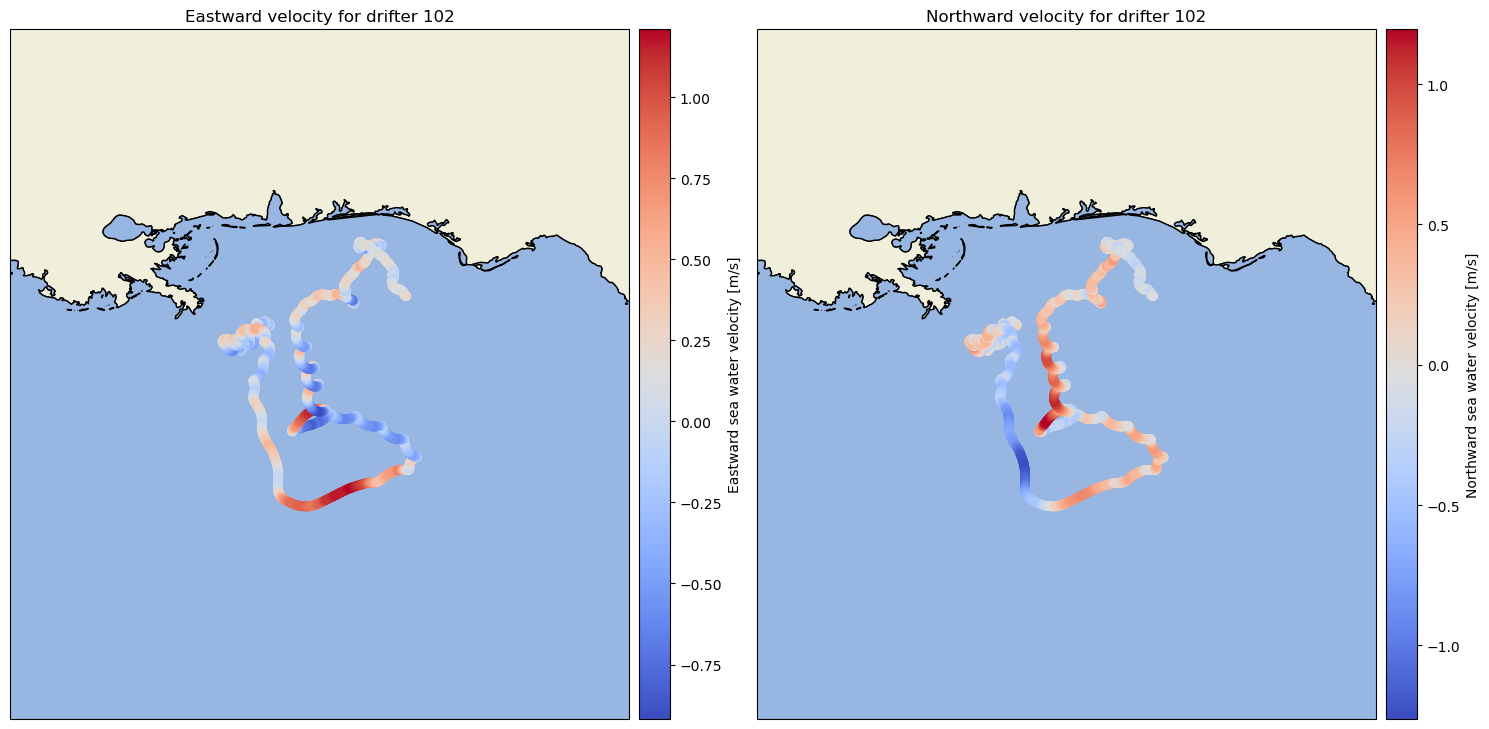

In [8]:
# Example dataset subset
ds_u = ds.u[sli]
ds_v = ds.v[sli]
ds_lat = ds.latitude[sli]
ds_lon = ds.longitude[sli]

fig = plt.figure(figsize=(15, 7.5))

map_extent = 3

# First subplot
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([ds_lon.min()-map_extent, ds_lon.max()+map_extent, \
                ds_lat.min()-map_extent, ds_lat.max()+map_extent], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.BORDERS)
ax1.coastlines()
sc1 = ax1.scatter(
    ds_lon, ds_lat,
    c=ds_u, cmap='coolwarm',
    transform=ccrs.PlateCarree()
)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cb1 = plt.colorbar(sc1, cax=cax1)
cb1.set_label('Eastward sea water velocity [m/s]')
ax1.set_title(f'Eastward velocity for drifter {drifter_number}')

# Second subplot
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([ds_lon.min()-map_extent, ds_lon.max()+map_extent, \
                ds_lat.min()-map_extent, ds_lat.max()+map_extent], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, edgecolor='black')
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.BORDERS)
ax2.coastlines()
sc2 = ax2.scatter(
    ds_lon, ds_lat,
    c=ds_v, cmap='coolwarm',
    transform=ccrs.PlateCarree()
)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cb2 = plt.colorbar(sc2, cax=cax2)
cb2.set_label('Northward sea water velocity [m/s]')
ax2.set_title(f'Northward velocity for drifter {drifter_number}')

plt.tight_layout()
plt.show()